# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.simplefilter("ignore")

In [4]:
# Открываем файл
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [5]:
# Посмотрим на общие сведения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
# В таблице 23699 строк и 22 колонки
# Посмотрим на первые 5 строк
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Уже по первым пяти строкам наблюдается немалое количество пропусков, а также неверно выводимый формат даты

### Предобработка данных

#### Посчитаем количество пропусков по колонкам и обработаем их

In [7]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

is_apartment           20924
parks_nearest          15620
ponds_nearest          14589
balcony                11519
ceiling_height          9195
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
dtype: int64

In [8]:
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

В колонке об апартаментах из `~23700` значений всего лишь `~2800` остались заполнены. <br/>
Среди них лишь `50 True` против `2725 False`. <br/>
Такое распределение не даст нам никакой статистической пользы, а заполнение пропусков чревато запутыванием системы автоматизирования, поэтому единственным приемлемым решением будет избавиться от этой колонки

In [9]:
df.drop('is_apartment', axis=1, inplace=True)

Некоторые пропуски в колонке `'parks_nearest'` мы можем заполнить средним значением в соответствии с населённым пунктом.<br> Например, если мы знаем среднее количество парков в Санкт-Петербурге, то можем заполнить пропуски в соответствующих строках

In [10]:
# Выведем уникальные названия населённых пунктов
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [11]:
# Всего по этой колонке 49 nan. По отношению к общей выборке это очень мало, поэтому смело от них избавляемся
df.dropna(subset=['locality_name'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [12]:
# В дальнейшем нам предстоит изменять строковые данные для устранения неявных дубликатов.
# Чтобы код был лаконичным, объявим функцию на регулярных выражениях
def change_string(old, new):
    for i in range(0, len(df)):
        if old in df['locality_name'][i]:
            df['locality_name'][i] = re.sub(fr'{old}', fr'{new}', df['locality_name'][i])

In [13]:
# Заменим все посЕлки на посЁлки
change_string('поселок', 'посёлок')

In [14]:
# Городской посёлок и посёлок городского типа – одно и то же. Изменим названия второго вида на названия первого
change_string('посёлок городского типа', 'городской посёлок')

In [15]:
# Посмотрим на количество уникальных значений и сами значения
display(len(df['locality_name'].sort_values().unique()))
df['locality_name'].sort_values().unique()

323

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Важины', 'городской посёлок Виллози',
       'городской посёлок Вознесенье', 'городской посёлок Вырица',
       'городской посёлок Дружная Горка', 'городской посёлок Дубровка',
       'городской посёлок Ефимовский', 'городской посёлок Кондратьево',
       'городской посёлок Красный Бор', 'городс

In [16]:
# Некоторые значения имеют одинаковые наименования, но разное лексическое окружение.
# Найдём таких замаскированных клонов и выведем количество их повторов
def only_names():
    lst = []
    for name in df['locality_name'].sort_values().unique():
        lst.append(''.join(re.findall(r'[а-я]?[А-Я].+', name)))
    return lst

for name, numb in Counter(only_names()).items():
    if numb > 1:
        print(name, numb)

Кудрово 2
Любань 2
Мурино 2
Никольское 2
Павлово 2
Приладожский 2
Рахья 2
Рябово 2
Фёдоровское 2
Гарболово 2
Зимитицы 2
Калитино 2
Рабитицы 2
Щеглово 2
Лесное 2
Громово 2
Вещево 2
Приветнинское 2


#### Сверим данные в [Интернете](https://lenobl.ru/o-regione/administrativno-territorialnoe-ustrojstvo/naselennye-punkty/) и проставим каждому наименованию свой муниципальный статус
*обозначим <span style="color:blue"> синим</span> цветом пояснения тех населённых пунктов, дубликаты которых необходимо убрать*

`Кудрово` - <span style="color:blue"> город</span><br>
`Любань` - есть город и есть посёлок (оставляем оба)<br>
`Мурино` - <span style="color:blue"> город</span><br>
`Никольское` - есть и город, и посёлок. Оставляем оба<br>
`Павлово` - есть и село, и городской посёлок. Оставляем оба<br>
`Приладожский` - <span style="color:blue"> в данных ошибка. СНТ называется ПриладожскОЕ и находится в Приладожском, поэтому меняем СНТ на городской посёлок</span><br>
`Рахья` - <span style="color:blue"> городской посёлок. Ситуация аналогична предыдущей. Переименовываем СНТ в посёлок, поскольку одно находится в другом</span>.<br>
`Рябово` - есть городской посёлок и есть посёлок. Оставляем оба<br>
`Фёдоровское` - есть городской посёлок и есть деревня. Оставляем оба<br>
`Гарболово` - <span style="color:blue"> деревня</span>.<br>
`Зимитицы` - есть и деревня, и посёлок. Оставляем оба<br>
`Калитино` - есть и деревня, и посёлок. Оставляем оба<br>
`Рабитицы` - есть и деревня, и посёлок. Оставляем оба<br>
`Щеглово` - есть и деревня, и посёлок. Ещё есть отдельный такой посёлок с торфопредприятем. Оставляем те, что имеем<br>
`Лесное` - есть и посёлок, и коттеджный посёлок, который находится в ином муниципалитете, поэтому оставляем оба.<br>
`Громово` - есть и посёлок, и посёлок при станции. Оставляем оба<br>
`Вещево` - <span style="color:blue"> в данных задвоение за счёт разной формулировки. Оставляем вариант "посёлок станции Вещево"</span>.<br>
`Приветнинское` - <span style="color:blue"> в данных задвоение за счёт разной формулировки. Оставляем вариант "посёлок станции Приветнинское"</span>

Итого 7 неявных дубликатов. В следующей ячейке произведём замену намеченных значений, а также подкорректируем "Лесную Поляну"

In [17]:
df.loc[df['locality_name'] == 'деревня Кудрово', 'locality_name']= 'Кудрово'
df.loc[df['locality_name'] == 'посёлок Мурино', 'locality_name'] = 'Мурино'
df.loc[df['locality_name'] == 'садовое товарищество Приладожский', 'locality_name'] = 'городской посёлок Приладожский'
df.loc[df['locality_name'] == 'садовое товарищество Рахья', 'locality_name'] = 'городской посёлок Рахья'
df.loc[df['locality_name'] == 'посёлок Гарболово', 'locality_name'] = 'деревня Гарболово'
df.loc[df['locality_name'] == 'посёлок при железнодорожной станции Вещево', 'locality_name'] = 'посёлок станции Вещево'
df.loc[df['locality_name'] == 'посёлок при железнодорожной станции Приветнинское', 'locality_name'] = 'посёлок станции Приветнинское'
df.loc[df['locality_name'] == 'садоводческое некоммерческое товарищество Лесная Поляна', 'locality_name'] = 'садовое товарищество Лесная Поляна'

In [18]:
# Выведем снова список уникальных названий и проверим на наличие примерно схожих
for name in only_names():
    display(name)

'Бокситогорск'

'Волосово'

'Волхов'

'Всеволожск'

'Выборг'

'Высоцк'

'Гатчина'

'Зеленогорск'

'Ивангород'

'Каменногорск'

'Кингисепп'

'Кириши'

'Кировск'

'Колпино'

'Коммунар'

'Красное Село'

'Кронштадт'

'Кудрово'

'Лодейное Поле'

'Ломоносов'

'Луга'

'Любань'

'Мурино'

'Никольское'

'Новая Ладога'

'Отрадное'

'Павловск'

'Петергоф'

'Пикалёво'

'Подпорожье'

'Приморск'

'Приозерск'

'Пушкин'

'Санкт-Петербург'

'Светогорск'

'Сертолово'

'Сестрорецк'

'Сланцы'

'Сосновый Бор'

'Сясьстрой'

'Тихвин'

'Тосно'

'Шлиссельбург'

'Большая Ижора'

'Будогощь'

'Важины'

'Виллози'

'Вознесенье'

'Вырица'

'Дружная Горка'

'Дубровка'

'Ефимовский'

'Кондратьево'

'Красный Бор'

'Кузнечное'

'Кузьмоловский'

'Лебяжье'

'Лесогорский'

'Мга'

'Назия'

'Никольский'

'Новоселье'

'Павлово'

'Приладожский'

'Рахья'

'Рощино'

'Рябово'

'Свирьстрой'

'Сиверский'

'Синявино'

'Советский'

'Тайцы'

'Токсово'

'Ульяновка'

'Форносово'

'Фёдоровское'

'Янино-1'

'Морозова'

'Свердлова'

'Агалатово'

'Аро'

'Батово'

'Бегуницы'

'Белогорка'

'Большая Вруда'

'Большая Пустомержа'

'Большие Колпаны'

'Большое Рейзино'

'Большой Сабск'

'Бор'

'Борисова Грива'

'Ваганово'

'Вартемяги'

'Вахнова Кара'

'Выскатка'

'Гарболово'

'Глинка'

'Горбунки'

'Гостилицы'

'Заклинье'

'Заневка'

'Зимитицы'

'Извара'

'Иссад'

'Калитино'

'Кальтино'

'Камышовка'

'Каськово'

'Келози'

'Кипень'

'Кисельня'

'Колтуши'

'Коркино'

'Котлы'

'Кривко'

'Кузьмолово'

'Курковицы'

'Куровицы'

'Куттузи'

'Лаврики'

'Лаголово'

'Лампово'

'Лесколово'

'Лопухинка'

'Лупполово'

'Малая Романовка'

'Малое Верево'

'Малое Карлино'

'Малые Колпаны'

'Мануйлово'

'Меньково'

'Мины'

'Мистолово'

'Ненимяки'

'Нижние Осельки'

'Нижняя'

'Низино'

'Новое Девяткино'

'Новолисино'

'Нурма'

'Оржицы'

'Парицы'

'Пельгора'

'Пеники'

'Пижма'

'Пикколово'

'Пудомяги'

'Пустынка'

'Пчева'

'Рабитицы'

'Разбегаево'

'Раздолье'

'Разметелево'

'Рапполово'

'Реброво'

'Русско'

'Сижно'

'Снегирёвка'

'Старая'

'Старая Пустошь'

'Старое Хинколово'

'Старополье'

'Старосиверская'

'Старые Бегуницы'

'Суоранда'

'Сяськелево'

'Тарасово'

'Терпилицы'

'Тихковицы'

'Тойворово'

'Торосово'

'Торошковичи'

'Трубников Бор'

'Фалилеево'

'Фёдоровское'

'Хапо-Ое'

'Хязельки'

'Чудской Бор'

'Шпаньково'

'Щеглово'

'Юкки'

'Ялгино'

'Яльгелево'

'Ям-Тесово'

'Кивеннапа Север'

'Лесное'

'Счастье'

'Александровская'

'Алексеевка'

'Аннино'

'Барышево'

'Белоостров'

'Бугры'

'Возрождение'

'Войсковицы'

'Войскорово'

'Володарское'

'Высокоключевой'

'Гаврилово'

'Гладкое'

'Глажево'

'Глебычево'

'Гончарово'

'Громово'

'Дзержинского'

'Дружноселье'

'Елизаветино'

'Жилгородок'

'Жилпосёлок'

'Житково'

'Заводской'

'Запорожское'

'Зимитицы'

'Ильичёво'

'Калитино'

'Каложицы'

'Кикерино'

'Кингисеппский'

'Кирпичное'

'Кобралово'

'Кобринское'

'Коммунары'

'Коробицыно'

'Котельский'

'Красная Долина'

'Красносельское'

'Левашово'

'Ленинское'

'Лесное'

'Лисий Нос'

'Лукаши'

'Любань'

'Мельниково'

'Металлострой'

'Мичуринское'

'Молодцово'

'Молодёжное'

'Мыза-Ивановка'

'Новогорелово'

'Новый Свет'

'Новый Учхоз'

'Оредеж'

'Пансионат Зелёный Бор'

'Парголово'

'Первомайское'

'Перово'

'Песочный'

'Петро-Славянка'

'Петровское'

'Платформа 69-й километр'

'Плодовое'

'Плоское'

'Победа'

'Поляны'

'Понтонный'

'Почап'

'Починок'

'Пригородный'

'Пудость'

'Пушное'

'Пчевжа'

'Рабитицы'

'Репино'

'Романовка'

'Ромашки'

'Ропша'

'Рябово'

'Сапёрное'

'Сапёрный'

'Севастьяново'

'Селезнёво'

'Сельцо'

'Семиозерье'

'Семрино'

'Серебрянский'

'Совхозный'

'Сосново'

'Старая Малукса'

'Стеклянный'

'Стрельна'

'Суйда'

'Сумино'

'Суходолье'

'Тельмана'

'Терволово'

'Торковичи'

'Торфяное'

'Тёсово-4'

'Углово'

'Усть-Ижора'

'Усть-Луга'

'Ушаки'

'Форт Красная Горка'

'Цвелодубово'

'Цвылёво'

'Шугозеро'

'Шушары'

'Щеглово'

'Вещево'

'Громово'

'Корнево'

'Лужайка'

'Приветнинское'

'Свирь'

'Лесная Поляна'

'Новая Ропша'

'Садко'

'Копорье'

'Никольское'

'Павлово'

'Паша'

'Путилово'

'Рождествено'

'Русско-Высоцкое'

'Старая Ладога'

'Шум'

In [19]:
# Сапёрный и Сапёрное – разные населённые пункты,
# причём Сапёрный – внутригородское образование СПб, а значит, мы можем его объединить с городом
df[df['locality_name'] == 'посёлок Сапёрный']['locality_name'] = 'Санкт-Петербург'
len(only_names())

316

#### Заполним пропуски в  `parks_around3000` `ponds_around3000`

In [20]:
# Логично предположить, что пропуски в указанных колонках соответствуют нулям.
# Если бы парки и водоёмы были бы в округе, их бы указали
# Заменим пропуски на нули

df.loc[df['parks_around3000'].isna(), 'parks_around3000'] = 0.0
df.loc[df['ponds_around3000'].isna(), 'ponds_around3000'] = 0.0

#### Заполним пропуски в `parks_nearest`

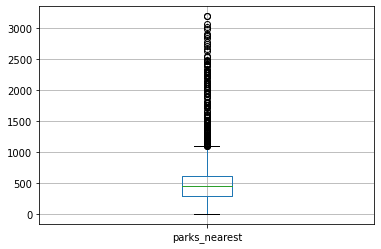

In [21]:
# Построим boxplot, чтобы увидеть ситуацию с выбросами
df.boxplot('parks_nearest');

In [22]:
# Выбросов немало, поэтому для заполнения воспользуемся медианой
# Посмотрим на описательные статистики и медианы 'parks_nearest' по городам
(
display(df[df['parks_nearest'].isna() == False][['parks_nearest']].describe(),
df.groupby('locality_name')['parks_nearest'].median().dropna())
)

,parks_nearest
count,8064.000000
mean,490.830729
std,342.554386
min,1.000000
25%,288.000000
50%,454.500000
75%,612.000000
max,3190.000000


locality_name
Зеленогорск          147.5
Колпино              393.0
Красное Село         428.5
Кронштадт            293.0
Ломоносов            407.0
Павловск             312.0
Петергоф             294.0
Пушкин               399.5
Санкт-Петербург      460.0
Сестрорецк           367.0
посёлок Парголово    733.0
посёлок Стрельна     700.0
Name: parks_nearest, dtype: float64

In [23]:
# Стандартное отклонение действительно велико, поэтому уверенно заполняем медианой,
# но сначала выведем таблицу с количеством пропусков по каждому городу
df[df['parks_nearest'].isna()][['locality_name']].value_counts()

locality_name           
Санкт-Петербург             8437
Мурино                       590
Кудрово                      472
посёлок Шушары               440
Всеволожск                   398
                            ... 
деревня Тойворово              1
деревня Тихковицы              1
деревня Терпилицы              1
деревня Старое Хинколово       1
село Шум                       1
Length: 316, dtype: int64

In [24]:
# Объявим функцию, которая будет заполнять пропуски в необходимом нам столбце медианой в соответствии с другим столбцом
# например: у нас пропуск в 'parks_nearest' напротив Зеленогорска, но мы знаем медиану по Зеленогорску в 'parks_nearest'
# соответственно, мы можем этой медианой заполнить пропущенные значения 'parks_nearest' напротив Зеленогорска

def fill_by_median(col_to_fill, col_to_take, around3000=None):
    grouped = df[[col_to_take, col_to_fill]].dropna().groupby(col_to_take)
    for city, length in grouped:
        df.loc[(df[col_to_fill].isna() == True) & (df[col_to_take] == city) & (around3000 != 0), col_to_fill] = float(length.median()) 

In [25]:
# В таблице есть ещё 3 колонки, подобные 'parks_nearest': 'ponds_nearest', 'cityCenters_nearest' и 'airports_nearest'
# Заполним пропуски в них нашей функцией и выведем результат изменения количества пропусков

fill_by_median('parks_nearest', 'locality_name', df['parks_around3000'])
fill_by_median('ponds_nearest', 'locality_name', df['ponds_around3000'])
fill_by_median('cityCenters_nearest', 'locality_name')
fill_by_median('airports_nearest', 'locality_name')

df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15586
ponds_nearest          14565
balcony                11513
ceiling_height          9160
airports_nearest        4830
cityCenters_nearest     4830
days_exposition         3180
kitchen_area            2269
living_area             1898
floors_total              85
dtype: int64

- Количество пропусков в `parks_nearest` стало примерно **на 40 меньше**<br>
- Количество пропусков в `cityCenters_nearest` и `airports_nearest` стало примерно **на 700 меньше**
- Количество пропусков в `ponds_nearest` стало **на 24 меньше**<br>

#### Заполним пропуски в `balcony`

In [26]:
df['balcony'].fillna(0, inplace=True)
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15586
ponds_nearest          14565
ceiling_height          9160
airports_nearest        4830
cityCenters_nearest     4830
days_exposition         3180
kitchen_area            2269
living_area             1898
floors_total              85
dtype: int64

#### Заполним пропуски в `ceiling_height`

In [27]:
# Посмотрим на общую информацию по данным
df['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [28]:
# В данных есть выбросы. Устраним их, поделив каждое значение, которое больше 10, на 10
for i in range(0, len(df)):
    if df['ceiling_height'][i] > 10:
        df.loc[i, 'ceiling_height'] /= 10 

count    14490.000000
mean         2.727846
std          0.299664
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         10.000000
Name: ceiling_height, dtype: float64

<AxesSubplot: >

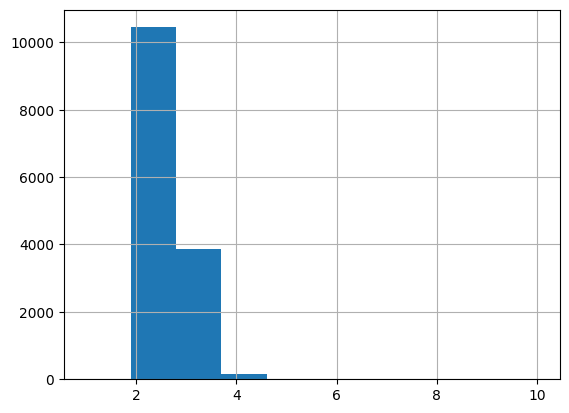

In [29]:
display(df['ceiling_height'].describe())
df['ceiling_height'].hist()

In [30]:
# Заполним пропуски медианой
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()

In [31]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15586
ponds_nearest          14565
airports_nearest        4830
cityCenters_nearest     4830
days_exposition         3180
kitchen_area            2269
living_area             1898
floors_total              85
dtype: int64

Как мы видели в описательной статистике, есть потолки с высотой в 1 м.<br> 
Согласно [официальным документам](https://www.cian.ru/stati-vysokie-potolki-za-i-protiv-312614/) высота потолков не должна быть ниже `2.5 м`<br>
Максимальная высота не регламентируется, однако более `4 м` в жизни практически не встречается<br>
Увидим, сколько таких

In [32]:
print('Аномально низкие:', df[df['ceiling_height'] < 2.5].shape[0])
print('Аномально высокие:', df[df['ceiling_height'] > 4].shape[0])

Аномально низкие: 78
Аномально высокие: 51


In [33]:
# Не так много в отношении всей выборки. Избавимся от этих аномальных строк
index_list = df[df['ceiling_height'] < 2.5].index
df.drop(index_list, inplace=True)
df = df.reset_index(drop=True)

In [34]:
index_list = df[df['ceiling_height'] > 4].index
df.drop(index_list, inplace=True)
df = df.reset_index(drop=True)

#### Пропуски в `days_exposition` логично оставить, поскольку это сигналы того, что объявления ещё не сняты
#### Заполним пропуски в `kitchen_area`

In [35]:
# Установим соответсвие 'total_area' напротив ПРОПУСКОВ 'kitchen_area' с 'total_area' напротив ЗНАЧЕНИЙ 'kitchen_area'
# то есть: если мы знаем, к примеру, значение 'kitchen_area' у конкретного 'total_area',
# то мы можем это же значение вставить вместо пропуска в 'kitchen_area' напротив того же 'total_area' 
df.loc[df['kitchen_area'].isna(), 'total_area'].isin(df.loc[df['kitchen_area'].isna() == False, 'total_area']).value_counts()

True     2045
False     208
Name: total_area, dtype: int64

In [36]:
# Заполним пропуски
for kitchen, total in zip(df.loc[df['kitchen_area'].isna() == False, 'kitchen_area'], df.loc[df['kitchen_area'].isna() == False, 'total_area']):
    df.loc[(df['kitchen_area'].isna()) & (df['total_area'] == total), 'kitchen_area'] = kitchen

In [37]:
df['kitchen_area'].fillna(df['kitchen_area'].median(), inplace=True)

In [38]:
# Сверим настоящее состояние пропусков
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15516
ponds_nearest          14491
airports_nearest        4794
cityCenters_nearest     4794
days_exposition         3161
living_area             1886
floors_total              85
dtype: int64

In [39]:
# Уберём из нашего фрейма нелогичные строки, то есть те, где площадь кухни и жилого помещения превышает общую площадь
index_list = df[df['kitchen_area'] + df['living_area'] > df['total_area']].index
df.drop(index_list, inplace=True)
df = df.reset_index(drop=True)

#### Заполним пропуски в `living_area`

In [40]:
# Проведём те же операции, что и в случае с 'kitchen_area'
df.loc[df['living_area'].isna(), 'total_area'].isin(df.loc[df['living_area'].isna() == False, 'total_area']).value_counts()

True     1739
False     147
Name: total_area, dtype: int64

In [41]:
for living, total in zip(df.loc[df['living_area'].isna() == False, 'living_area'], df.loc[df['living_area'].isna() == False, 'total_area']):
    df.loc[(df['living_area'].isna()) & (df['total_area'] == total), 'living_area'] = living

In [42]:
df['living_area'].fillna(df['living_area'].median(), inplace=True)

In [43]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15355
ponds_nearest          14354
airports_nearest        4746
cityCenters_nearest     4746
days_exposition         3147
floors_total              83
dtype: int64

In [44]:
# После наших операций вновь могли образоваться нелогичные строки, где сумма площадей кухни и жилого помещения больше общей
df[df['kitchen_area'] + df['living_area'] > df['total_area']].shape[0]

52

In [45]:
# 52 строки. УДалим их прежним методом
index_list = df[df['kitchen_area'] + df['living_area'] > df['total_area']].index
df.drop(index_list, inplace=True)
df = df.reset_index(drop=True)
df[df['kitchen_area'] + df['living_area'] > df['total_area']].shape[0]

0

#### Пропусков в `floors_total` – `83` на `23528` наблюдений, соответственно, избавление от них не повлечёт за собой значительных статистических изменений

In [46]:
df.dropna(subset=['floors_total'], inplace=True)
df = df.reset_index(drop=True)
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

parks_nearest          15268
ponds_nearest          14288
airports_nearest        4728
cityCenters_nearest     4728
days_exposition         3135
dtype: int64

#### Изменяем типы данных

In [47]:
# Посмотрим, какие типы у нас есть
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [48]:
# Изменим колонку с датой на формат даты.
# Также изменим на целые числа балконы, этажность, количество парков и водоёмов вокруг. 
# Количество дней, которое висело объявление, увы, изменить мы не сможем за счёт пристутсвия Nan'ов
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

df[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']] = \
df[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']].astype('int64')

df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                float64
dtype: object

**Вывод по итогу предобработки данных:**

В результате проделанной работы мы 
- справились с неявными дубликатами в наименованиях населённых пунктов,
- полностью избавились от нерабочей колонки `is_apartment` и убрали оставшиеся после обработки 83 строки с Nan в `floors_total` 
- заполнили пропуски логически подходящими значениями(например, в неуказанных количествах парков, водоёмов вокруг и балконов),
- изменили тип данных с датой на `datetime` и некоторые другие на `int`
- а также избавились от аномальных значений в параметрах, касающихся высоты потолков, и от неправильных строк, где суммарная площадь кухни и жилого помещения превышала общую

### Посчитаем и добавим в таблицу новые столбцы

#### Посчитаем и добавим в таблицу цену одного квадратного метра

In [49]:
# Сделаем расчёты и переставим колонку ближе к делимому и делителю для наглядности в самом фрейме
df.insert(3, column='price_meter²', value=(round(df['last_price'] / df['total_area'])))

In [50]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'price_meter²',
       'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total',
       'living_area', 'floor', 'studio', 'open_plan', 'kitchen_area',
       'balcony', 'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Посчитаем и добавим в таблицу день, месяц и год публикации объявления

In [51]:
df.insert(5, column='weekday', value=(df['first_day_exposition'].dt.weekday))
df.insert(6, column='month', value=(df['first_day_exposition'].dt.month))
df.insert(7, column='year', value=(df['first_day_exposition'].dt.year))

In [52]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'price_meter²',
       'first_day_exposition', 'weekday', 'month', 'year', 'rooms',
       'ceiling_height', 'floors_total', 'living_area', 'floor', 'studio',
       'open_plan', 'kitchen_area', 'balcony', 'locality_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'parks_nearest', 'ponds_around3000', 'ponds_nearest',
       'days_exposition'],
      dtype='object')

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Хорошо используешь insert

#### Посчитаем и добавим в таблицу тип этажа квартиры (значения — «первый», «последний», «другой»)

In [53]:
# Объявим функцию, выявляющую этот тип по этажности и этажу в объявлении, и создадим соответствующую колонку
def get_type_floor(t, f):
    lst = []
    for total, floor in zip(t, f):
        if floor == 1:
            lst.append('первый')
        elif floor == total:
            lst.append('последний')
        else:
            lst.append('другой')
    return lst

df.insert(13, column='type_floor', value=(get_type_floor(df['floors_total'], df['floor'])))

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Рабочая функция

In [54]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'price_meter²',
       'first_day_exposition', 'weekday', 'month', 'year', 'rooms',
       'ceiling_height', 'floors_total', 'living_area', 'floor', 'type_floor',
       'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'parks_nearest', 'ponds_around3000', 'ponds_nearest',
       'days_exposition'],
      dtype='object')

#### Посчитаем и добавим в таблицу расстояние в км до центра города

In [55]:
df['cityCenters_nearest']
df.insert(21, column='cityCenters_km', value=(df['cityCenters_nearest'] / 1000))

In [56]:
df[['cityCenters_nearest', 'cityCenters_km']]

,cityCenters_nearest,cityCenters_km
0,16028.0,16.028
1,18603.0,18.603
2,13933.0,13.933
3,6800.0,6.800
4,8098.0,8.098
...,...,...
23182,4232.0,4.232
23183,NaN,NaN
23184,NaN,NaN
23185,10364.0,10.364


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Великолепно, все пункты задания выполнены в полном объёме

### Проведём исследовательский анализ данных

#### **Изучим необходимые параметеры**

**Выведем гистограмму и описательную статистику `total_area`**

count    23187.000000
mean        60.421723
std         35.089158
min         14.000000
25%         40.100000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

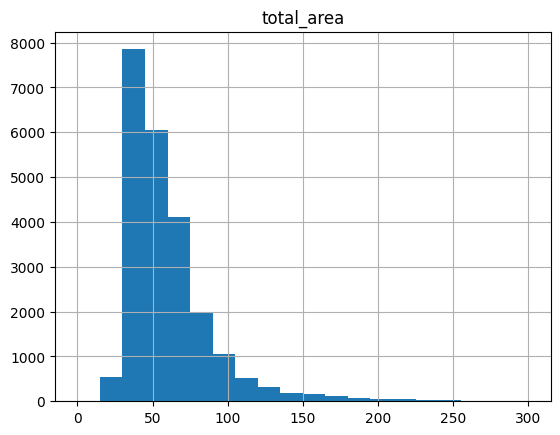

In [57]:
# Поскольку мы будем описывать многие колонки, объявим функцию, возвращающую описательную статистику и гистограмму
def stat_n_hist(col, bins=10, range=None):
    df[col].hist(bins=bins, range=range)
    plt.title(col)
    return df[col].describe()

stat_n_hist('total_area', bins=20, range=(0, 300))

`Наиболее распространены` объявления с квартирами в `~50 кв.м` общей площади<br>
Далее с увеличением общей площади количество объявлений постепенно падает

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Хорошо

**Выведем гистограмму и описательную статистику `living_area`**

count    23187.000000
mean        34.391931
std         21.461369
min          2.000000
25%         18.700000
50%         30.000000
75%         42.400000
max        409.700000
Name: living_area, dtype: float64

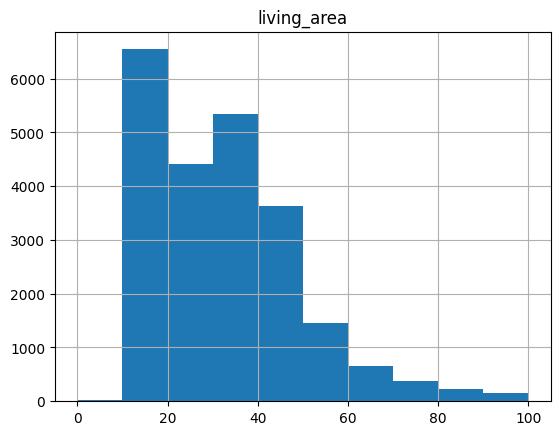

In [58]:
stat_n_hist('living_area', range=(0, 100))

`От 10 до 40 кв.м` – наиболее распространённая `жилая площадь` в объявлениях<br>
Чем больше жилая площадь указанного диапозона, тем меньше объявлений

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Выглядит правдоподобно

**Выведем гистограмму и описательную статистику `kitchen_area`**

count    23187.000000
mean        10.441979
std          5.823770
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64

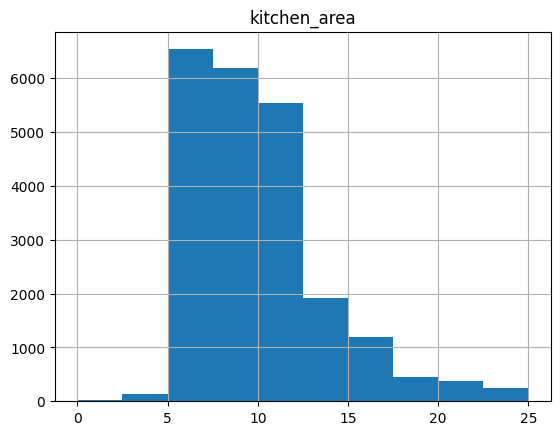

In [59]:
stat_n_hist('kitchen_area', range=(0,25))

`От 5 до 12 кв.м` – наиболее распространённая `площадь кухни` в объявлениях<br>
Чем больше площадь кухни указанного диапозона, тем меньше объявлений

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Верно

**Выведем гистограмму и описательную статистику `last_price`**

In [60]:
# В данной колонке значения – миллионные, а значит, отображаться будут через буквы на конце.
# Чтобы избежать такого путающего вида данных, отформатируем вывод и вручную сделаем describe() и hist()
df['last_price'].describe().apply("{0}".format)

count               23187.0
mean     6516951.8727735365
std       10755495.81567566
min                 12190.0
25%               3450000.0
50%               4650000.0
75%               6800000.0
max             763000000.0
Name: last_price, dtype: object

In [61]:
# Минимальное значение параметра – 12190, что является безусловной аномалией избавимся от неё
index_to_drop = df[df['last_price'] == 12190].index
df.drop(index_to_drop, inplace=True)
df = df.reset_index(drop=True)
df['last_price'].describe().apply("{0}".format)

count               23186.0
mean      6517232.419736047
std      10755642.921508936
min                430000.0
25%               3450000.0
50%               4650000.0
75%               6800000.0
max             763000000.0
Name: last_price, dtype: object

<AxesSubplot: >

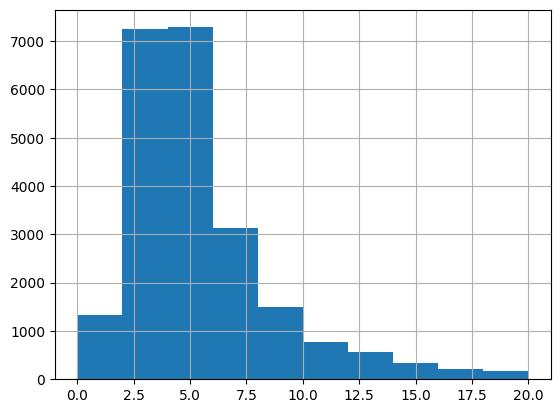

In [62]:
# Для корректного отображения гистограммы поделим значения на миллион
def div(x):
    return x / 1000000
df['last_price'].apply(div).hist(range=(0,20))

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> А вот тут стоит заметить, что одна явная аномалия в данных была пропущена

<div class="alert alert-info"> <b>Комментарий студента:</b> Не углядел) исправил данные чуть выше</div>

`От 2.5 до 6 миллионов` – наиболее распространённая `цена` в объявлениях<br>
Чем больше цена указанного диапозона, тем меньше объявлений

**Выведем гистограмму и описательную статистику `rooms`**

count    23186.000000
mean         2.078366
std          1.072740
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

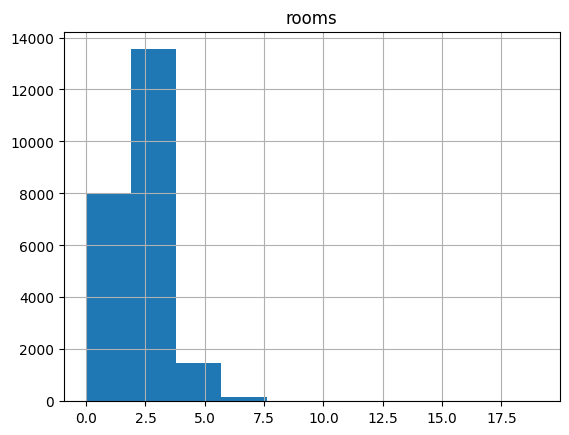

In [63]:
stat_n_hist('rooms')

In [64]:
# В таблице есть квартиры с нулём комнат. Скорее всего, это студии или квартиры с открытой планировкой. 
# Проверим их соотношение
print('С открытой планировкой', df[(df['rooms'] == 0) & (df['open_plan'] == True)].shape[0])
print('Студии', df[(df['rooms'] == 0) & (df['studio'] == True)].shape[0])
print('Всего:', df[df['rooms'] == 0].shape[0])

С открытой планировкой 42
Студии 96
Всего: 138


Пользователь мог сознательно указать нули в данном параметре,<br>
чтобы тем самым показать: в объявлении студия или квартира с открытой планировкой.<br>
Оставим эти значения как важные сигналы

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Не соглашусь с таким удалением. Объекты с 0 комнат стоит также проверить на открытые планировки, вполне возможно владелец объявления вполне сознательно установил 0 комнат и какой-то критической ошибки это точно не вносит

In [65]:
# На гистограме и дескрайбе отчётливо видно, что есть и аномально большое количество комнат
# Посмотрим на их долю от общей выборки.
# Исходя из результатов гистоограммы, возьмём значения больще 7
print('Количество объявлений с комнатами > 7:', df[df['rooms'] > 7].shape[0])
print('Доля от общей выборки:', round(df[df['rooms'] > 7].shape[0] / df.shape[0] * 100, 1))

Количество объявлений с комнатами > 7: 30
Доля от общей выборки: 0.1


In [66]:
# Доля квартир с комнатами больше 7 составляет 0.1%
# Чтобы программа по автоматизации результатов объявлений, для работы которой мы готовим данные,
# не учитывала такие аномалии, уберём эти строки
index_list = df[df['rooms'] > 7].index
df.drop(index_list, inplace=True)
df = df.reset_index(drop=True)

count    23156.000000
mean         2.068017
std          1.029302
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

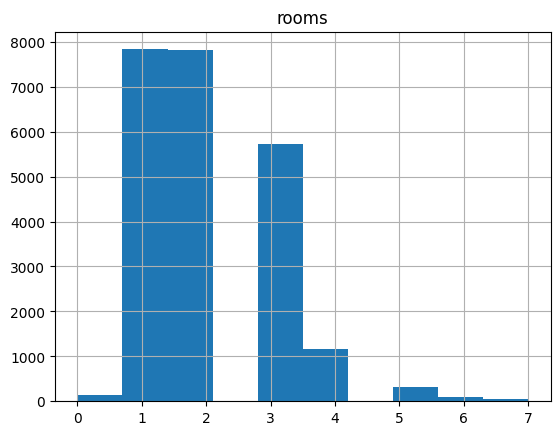

In [67]:
# Выведем снова статистику и гистограмму по комнатам
stat_n_hist('rooms')

Квартиры с `1 и 2 комнатами` – наиболее распространёны в объявлениях<br>
Чем больше комнат указанного диапозона, тем меньше объявлений

**Выведем гистограмму и описательную статистику `ceiling_height`**

count    23156.000000
mean         2.693731
std          0.203643
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64

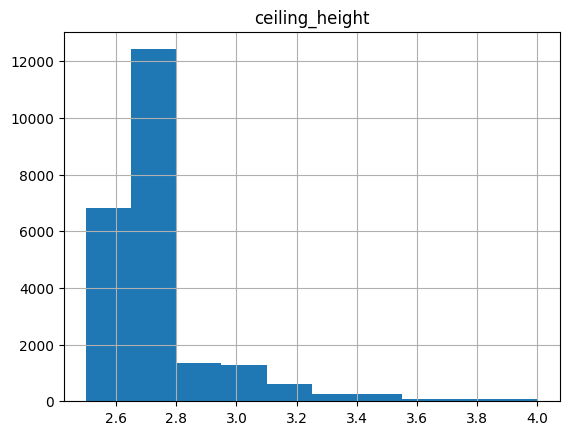

In [68]:
stat_n_hist('ceiling_height')

Квартиры с высотой потолков `до 2.8 м` – наиболее распространёны в объявлениях<br>
Чем больше высота потолков указанного значения, тем меньше объявлений

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Все корректно

**Выведем гистограмму и описательную статистику `floor`**

count    23156.000000
mean         5.864614
std          4.856270
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

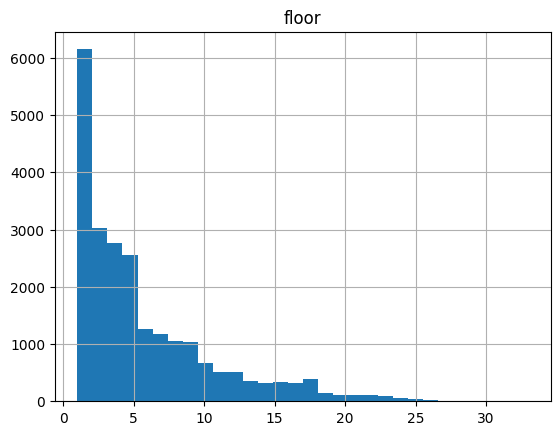

In [69]:
stat_n_hist('floor', bins=30)

Квартиры с `1 по 5 этажи` – наиболее распространёны в объявлениях<br>
Чем выше этаж указанного диапазона, тем меньше объявлений

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> В основном застройка низкоэтажная

**Выведем гистограмму и описательную статистику `type_floor`**

count      23156
unique         3
top       другой
freq       17053
Name: type_floor, dtype: object

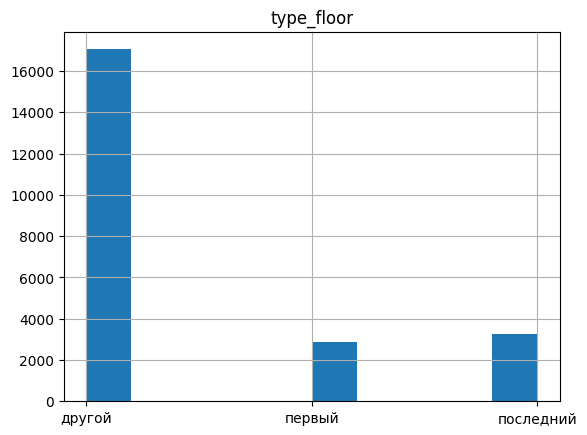

In [70]:
stat_n_hist('type_floor')

Квартиры с типом этажа `другой` встречаются чаще, чем первый и последний, примерно `в 6 раз`

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Странно, если было бы иначе

**Выведем гистограмму и описательную статистику `floors_total`**

count    23156.000000
mean        10.655985
std          6.570251
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

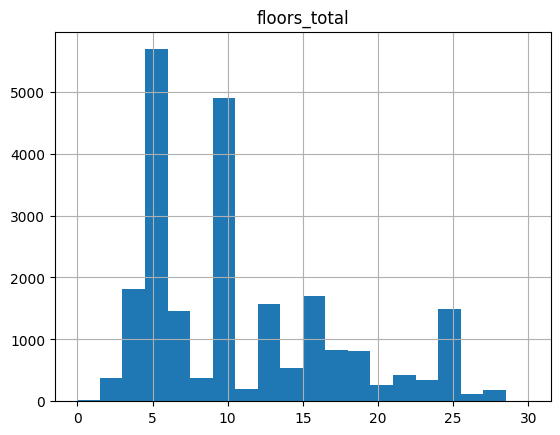

In [71]:
stat_n_hist('floors_total', bins=20, range=(0,30))

In [72]:
df['floors_total'].value_counts().sort_values(ascending=False).head()

5     5686
9     3730
16    1350
12    1342
4     1170
Name: floors_total, dtype: int64

Квартиры в `5- и 9-этажных` домах встречаются чаще остальных<br>
Чем больше этажей указанного диапазона, тем меньше объявлений

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> 10-этажные ли?)

**Выведем гистограмму и описательную статистику `cityCenters_nearest`**

count    18428.000000
mean     14488.413990
std       8609.871575
min        181.000000
25%       9549.750000
50%      13277.000000
75%      16744.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

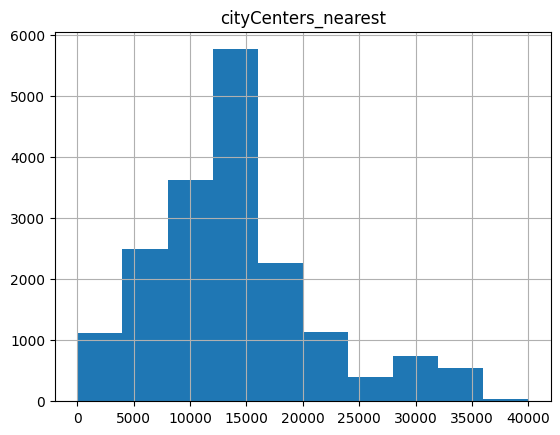

In [73]:
stat_n_hist('cityCenters_nearest', range=(0,40000))

В выборке в наибольшем количестве представлены квартиры с `расстоянием до центра` города `от 10 до 15 км`

**Выведем гистограмму и описательную статистику `airports_nearest`**

count    18428.00000
mean     29540.00681
std      13064.60128
min          0.00000
25%      18766.00000
50%      27261.50000
75%      38786.00000
max      84869.00000
Name: airports_nearest, dtype: float64

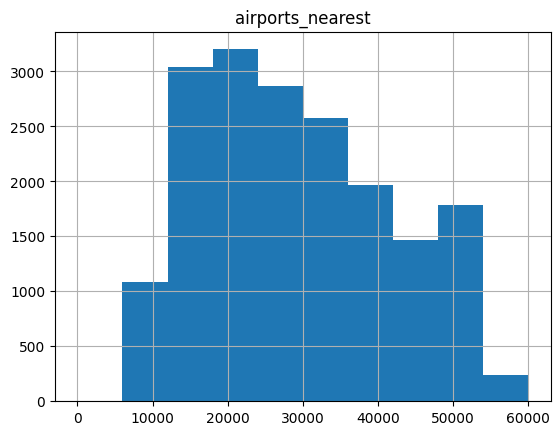

In [74]:
stat_n_hist('airports_nearest', range=(0,60000))

В выборке в наибольшем количестве представлены квартиры с `расстоянием до аэропорта` `от 10.1 до 30.5 км`

**Выведем гистограмму и описательную статистику `parks_nearest`**

count    7893.000000
mean      490.493349
std       341.365404
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

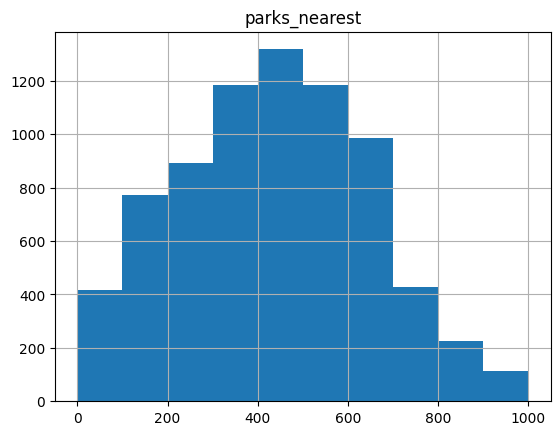

In [75]:
stat_n_hist('parks_nearest', range=(0,1000))

В выборке в наибольшем количестве представлены квартиры с `расстоянием до парка` `от 300 до 600 м`

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Все параметры удаленности разобраны

**Выведем гистограмму и описательную статистику `weekday`**

count    23156.000000
mean         2.567456
std          1.788077
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

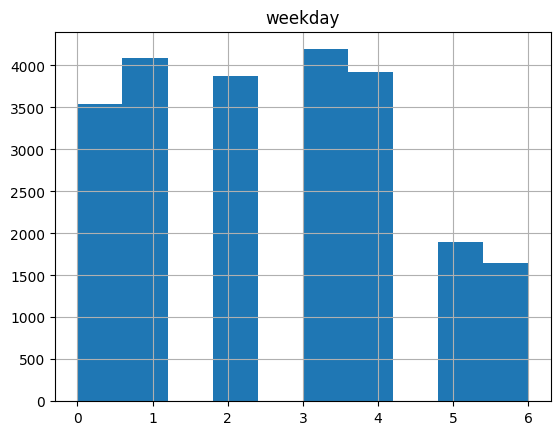

In [76]:
stat_n_hist('weekday')

`В 2 раза чаще` объявления о продаже квартиры выставляют `в будние дни`

**Выведем гистограмму и описательную статистику `month`**

count    23156.000000
mean         6.400069
std          3.493980
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

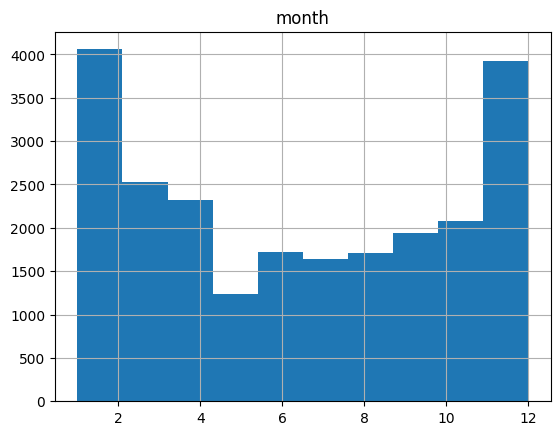

In [77]:
stat_n_hist('month')

`Зимой` объявления выставляют `в 2 раза чаще`, чем в другие сезоны.<br>
В конце весны и всё лето наблюдается наименьшее количество предложений

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Анализ временных показателей также проведен

#### Изучим, как быстро продавались квартиры

count    20028.000000
mean       180.995456
std        219.755293
min          1.000000
25%         45.000000
50%         95.500000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

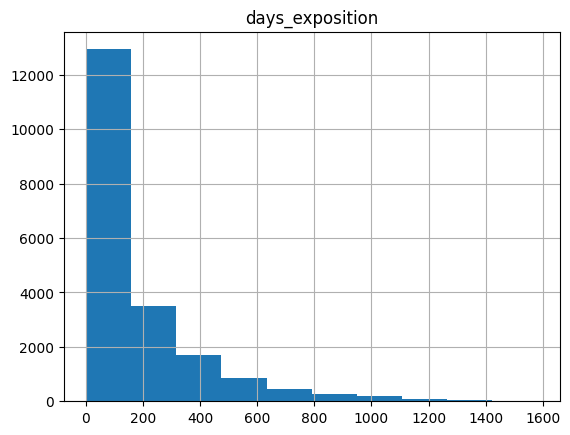

In [78]:
stat_n_hist('days_exposition')

Наиболее часто продаются квартиры в диапозоне `от 1 до 200 дней`<br>
Посмотрим на самую быструю и долгую продажу и попробуем понять причины

In [79]:
# Поскольку мы хотим понять закономерности, повлиявшие на аномально быструю и аномально долгую скорость продажи квартиры, 
# нам потребуется видеть перед собой все колонки фрейма
pd.set_option('display.max_columns', None)

In [80]:
df[df['days_exposition'] == 1]

,total_images,last_price,total_area,price_meter²,first_day_exposition,weekday,month,year,rooms,ceiling_height,floors_total,living_area,floor,type_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,cityCenters_km,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1594,19,4000000.0,49.9,80160.0,2019-05-01,2,5,2019,2,2.5,9,25.0,1,первый,False,False,10.0,0,Санкт-Петербург,13567.0,14384.0,14.384,1,20.0,1,681.0,1.0


- Цена данной квартиры входит в диапозон наиболее распространённых
- Месяц выставления объявления наименее богат на предложения, согласно одному из предыдущих графиков,<br>
а значит, выбирать покупателям приходилось меньше
- Город – наиболее распространённый среди как спроса, так и предложения
- Недалеко аэропорт
- Высокое количество фотографий
- В целом, все параметры указаны, нет ни одного пропуска, что также влияет на привлечение внимания

In [81]:
df[df['days_exposition'] == 1580]

,total_images,last_price,total_area,price_meter²,first_day_exposition,weekday,month,year,rooms,ceiling_height,floors_total,living_area,floor,type_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,cityCenters_km,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18426,11,3500000.0,48.2,72614.0,2014-12-15,0,12,2014,2,2.5,5,27.4,2,другой,False,False,7.7,3,деревня Новое Девяткино,NaN,NaN,NaN,0,NaN,0,NaN,1580.0


- Множество пропущенных значений и нулей в количественных данных
- Квартира выставлена в одном из самых богатых на предложения месяце – январе, – а как мы помним, всю зиму сайт заполнен предложениями. Квартира могла "затеряться" среди иных объявлений
- Не столь привлекательный, в отличие от города, населённый пункт
- Также стоит отметить, что объявление выпало на кризис в стране 2014-2015 гг

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Тут по заданию имелось в виду определить именно границы для типовых "быстрых" и "долгих" продаж, но такой подход тоже интересный)

#### Исследуем, какие из следующих факторов больше всего влияют на общую (полную) стоимость объекта
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год);

In [82]:
# Посмотрим на корреляцию данных, кроме 'type_floor', поскольку здесь находятся категориальные данные
df.corr()[['last_price']].loc[['total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday', 'month', 'year']]

,last_price
total_area,0.634240
living_area,0.526433
kitchen_area,0.453463
rooms,0.345298
weekday,0.002209
month,0.000803
year,-0.040882


***Сильнее*** всего цена квартиры зависит от `общей площади` и `жилой`, ***менее*** – от `площади кухни` и `количества комнат`<br>
По временным данным корреляция самая слабая

In [83]:
# Объявим функцию, которая будет строить диаграмму рессеяния 
# на основе сводной таблицы цены и нужного нам параметра в медианном соотношении
# Для читаемого вывода используем уже созданную нами другую функцию, делящую значения на миллион

new_df = df.copy()
new_df['last_price'] = new_df['last_price'].apply(div)
def get_price_piv(col):
    price_piv = new_df.pivot_table(index=col, values='last_price')
    price_piv = price_piv.reset_index().set_axis([col, 'last_price'], axis=1)
    price_piv.plot.scatter(x=col, y='last_price')

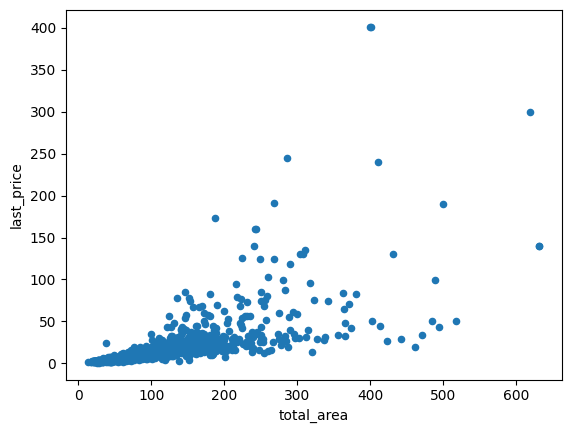

In [84]:
# Проанализируем зависимость цены от общей площади
get_price_piv('total_area')

В пределах примерно `до 200 кв.м общей площади` цена недвижимости линейно растёт 

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Верно

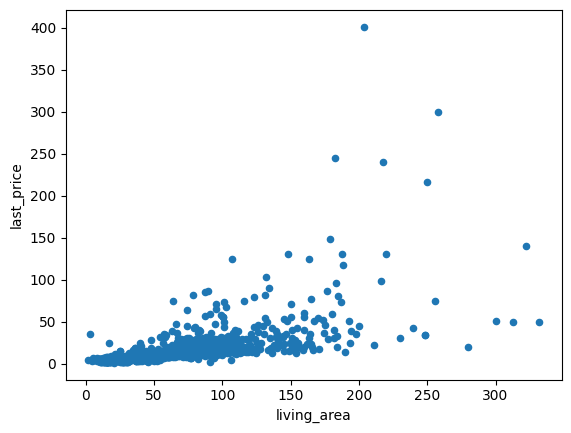

In [85]:
# Проанализируем зависимость цены от жилой площади
get_price_piv('living_area')

В пределах примерно до `150 кв.м жилой площади` цена недвижимости линейно растёт

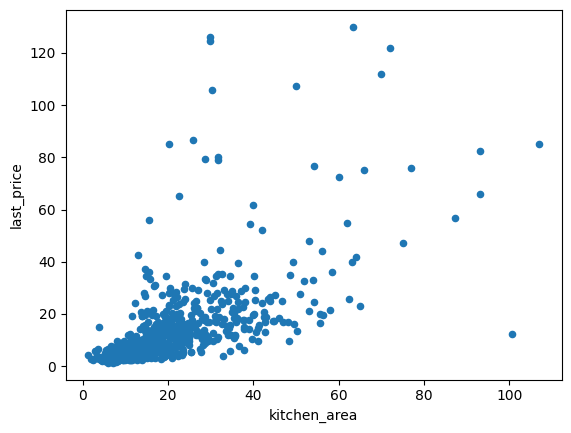

In [86]:
# Проанализируем зависимость цены от площади кухни
get_price_piv('kitchen_area')

В пределах примерно до `25 кв.м площади кухни` цена недвижимости линейно растёт

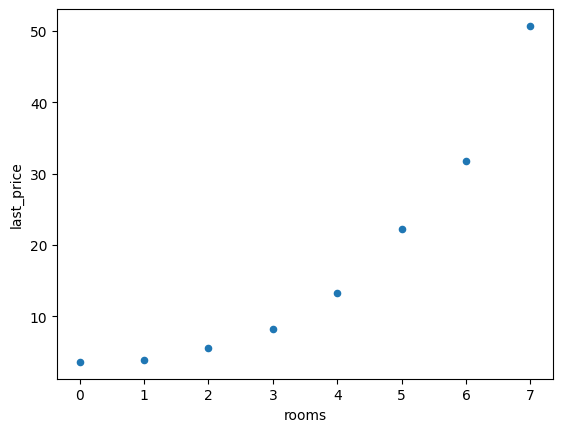

In [87]:
# Проанализируем зависимость цены от количества комнат
get_price_piv('rooms')

`Чем больше комнат, тем выше цена`<br>
Не удивительно, что корреляция показала малое значение, ведь она фиксирует лишь линейную зависимость,<br>
а у нас налицо `экспоненциальный рост`

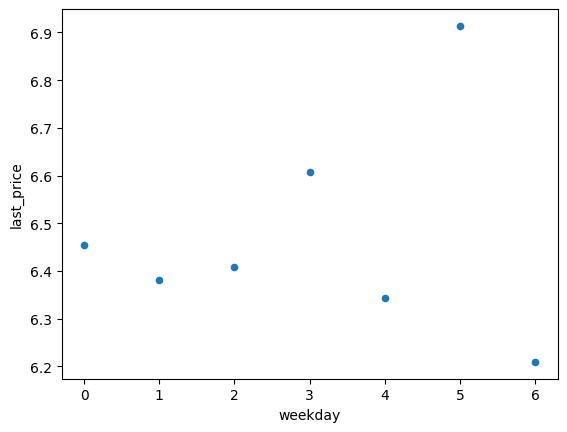

In [88]:
# Проанализируем зависимость цены от дня недели
get_price_piv('weekday')

`Зависимость` цены от `дня недели` выставления объявления `не наблюдается`

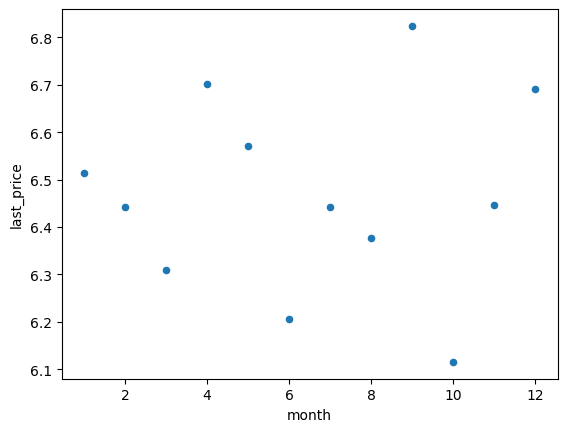

In [89]:
# Проанализируем зависимость цены от месяца
get_price_piv('month')

`Зависимость` цены от `месяца` выставления объявления `не наблюдается`

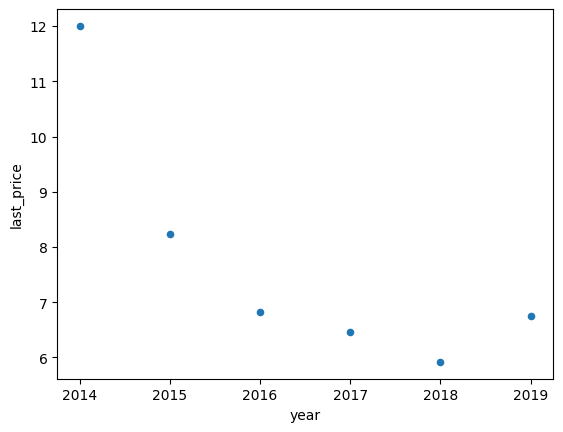

In [90]:
# Проанализируем зависимость цены от года
get_price_piv('year')

`С 2014 по 2018 год` цена недвижимости `экспоненциально уменьшалась`, а вот в `2019` году заметна `предпосылка роста`<br>
Как мы уже сказали, падение, возможно, обусловлено начавшимся в 2014 году российским кризисом

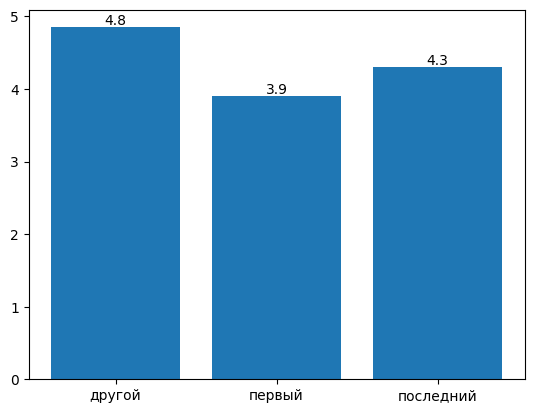

In [91]:
# Проанализируем зависимость цены от типа этажа
# Для этого мы вручную построим сводную таблицу и выведем столбчатый график, 
# поскольку scatter не работает с категориальными данными
type_floor_piv = new_df.pivot_table(index='type_floor', values='last_price', aggfunc='median')
container = plt.bar(type_floor_piv.index, type_floor_piv['last_price'])
labels = list(round(type_floor_piv['last_price'], 1))
plt.bar_label(container=container, labels=labels);

`Первый этаж` недвижимости `снижает` её `стоимость` примерно на `1 миллион`

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [92]:
# Выделим 10 населённых пунктов с наибольшим количеством объявлений
df['locality_name'].value_counts().sort_values(ascending=False).head(10)

Санкт-Петербург      15396
Мурино                 548
Кудрово                452
посёлок Шушары         437
Всеволожск             388
Пушкин                 365
Колпино                334
посёлок Парголово      325
Гатчина                303
Выборг                 233
Name: locality_name, dtype: int64

In [93]:
# Выделим в список наиболее распространённые населённые пункты и построим сводную таблицу

popular_names = df['locality_name'].value_counts().sort_values(ascending=False).head(10).index
names_n_price = df[df['locality_name'].isin(popular_names)][['locality_name', 'price_meter²']]
names_n_price.groupby('locality_name').mean().sort_values('price_meter²', ascending=False).agg('round')

,price_meter²
locality_name,
Санкт-Петербург,114477.0
Пушкин,103080.0
Кудрово,95131.0
посёлок Парголово,90165.0
Мурино,85561.0
посёлок Шушары,78388.0
Колпино,75426.0
Всеволожск,68713.0
Гатчина,68625.0


Самый **дорогой** кв.м: `Санкт-Петербург ~ 114419 р.`<br>
Самый **дешёвый** кв.м: `Выборг ~ 58203 р.`

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Ты правильно ответил на вопрос задания!

#### Исследуем, как стоимость объектов Санкт-Петербурга зависит от расстояния до центра города

<AxesSubplot: xlabel='cityCenters_km', ylabel='last_price'>

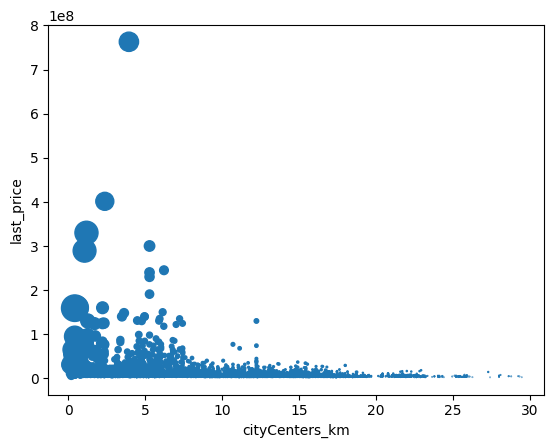

In [94]:
# Сделаем срез исходного фрейма из цены и расстояния до центра в километрах
# Добавим столбец с ценой за 1 км до центра
# Построим диаграмму рассеяния из трёх полученных переменных:
# x = расстояние до центра
# y = цена
# размер точки будет передавать цену за 1 км

df[df['locality_name'] == 'Санкт-Петербург'][['last_price', 'cityCenters_km']]
mean_price_km = df[df['locality_name'] == 'Санкт-Петербург'][['last_price', 'cityCenters_km']].copy()
mean_price_km['price_1_km'] = mean_price_km['last_price'].apply(div) / mean_price_km['cityCenters_km']
mean_price_km.plot.scatter(x='cityCenters_km', y='last_price', s='price_1_km')

На графике мы видим, что `самые высокие цены` за 1 км имеют объекты в радиусе `5 км от центра` города

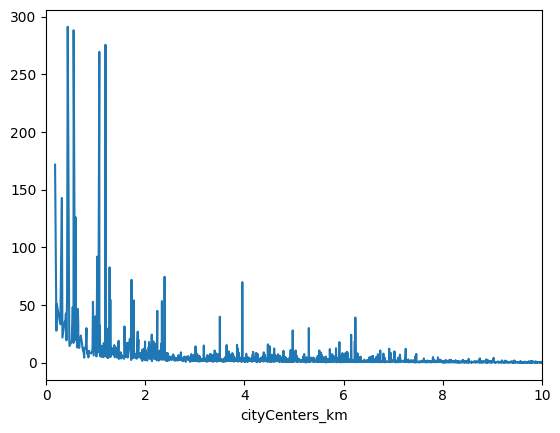

In [95]:
mean_price_km.groupby('cityCenters_km')['price_1_km'].mean().plot(xlim=(0,10));

Линейный график позволил нам уточнить:<br>
`Первые 1.5 километра` – самые дорогие в объявлениях, цена может варьироваться `от 140 до 290 тысяч`<br>
Начиная `с 4 километра`, цена `не превышает 50 тысяч`

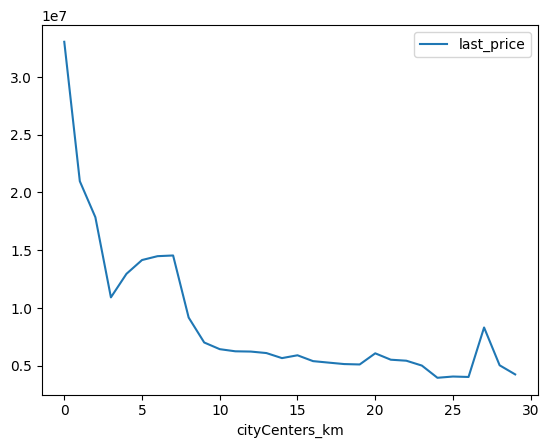

In [96]:
mean_price_kms = df[df['locality_name'] == 'Санкт-Петербург'].copy()
mean_price_kms['cityCenters_km'] = round(mean_price_kms['cityCenters_km'])
mean_price_kms.pivot_table(index='cityCenters_km', values='last_price').plot();

<div class="alert alert-info"> <b>Комментарий студента:</b> Построил дополнительно линейный график и написал выводы по наиболее характерным диапозонам высоких и низких цен за километр</div>

### Общий вывод

Для определения рыночной стоимости объекта недвижимости в Санкт-Петербурге необходимо учитывать следующие закономерности:

Цена линейно растёт на отрезках параметров:

- Общая площадь – до `200 кв.м` 

- Жилая площадь – до `150 кв.м`

- Площадь кухни – до `25 кв.м`

Увеличение количества комнат повышает общую стоимость недвижимости,<br>
а вот расположение объекта на 1 этаже снижает её стоимость в среднем на миллион

Стоимость 1 кв.м. до центра города варьируется между `114419` и `58203` рублями

Самые высокие цены за 1 км имеют объекты в радиусе `5 км от центра` города

<div class="alert alert-info"> <b>Комментарий студента:</b> Огромное спасибо за конструктивное ревью! Счастья, добра, удачи и карьерных успехов!))</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v 2.0 ✔️:</b> Спасибо, взаимно! Это в такие времена никому не помешает)</div>

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод